In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
import difflib
import graphviz
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets

In [2]:
class FeatureSelection:
    def __init__(self, data, classes, min_col, features, population):
        self.classes = classes
        self.data = data
        self.population = {}
        self.selective_pressure = 1.5
        self.number_of_best = 1
        self.num_of_genes = features
        self.mutation_rate = 1/self.num_of_genes
        self.min_col = min_col
        self.N = population
     
    def init_population(self):
        for i in range(self.N):
            self.population[i] = np.random.randint(2, size=self.num_of_genes)
            if not np.any(self.population[i]):
                while not np.any(self.population[i]):
                    self.population[i] = np.random.randint(2, size=self.num_of_genes)
   
    def weighted_random_choice(self,fitness):
        max = sum(fitness.values())
        pick = np.random.uniform(0, max)
        current = 0
        for key, value in fitness.items():
            current += value
            if current > pick:
                return key
            
    def elitism(self,fitness):
        sorted_fitness = sorted(fitness, key=fitness.get)
        return sorted_fitness[len(sorted_fitness) - self.number_of_best:]

    def select_parents(self,fitness):
        parents = {}
        n_N = int(self.N/2)
        best = self.elitism(fitness)
        for n in range(0, n_N - len(best)):
            key = self.weighted_random_choice(fitness)
            parents[n] = self.population[key]
        for n in range(0, len(best)):
            key = best[n]
            parents[n_N - len(best) + n - 1] = self.population[key]
        return parents
    
    def crossover(self,parents):
        new_generation = {}
        ch = 0
        while len(new_generation) != self.N:
            pair = np.zeros((2,self.num_of_genes))
            parent1 = np.random.randint(low=0,high=len(parents))
            parent2 = np.random.randint(low=0,high=len(parents))
            if parent1 == parent2:
                while parent1 != parent2:
                    parent2 = np.random.randint(low=0,high=len(parents))
            pair[0] = parents[parent1]
            pair[1] = parents[parent2]
            crossover_point = np.random.randint(low=1,high=self.num_of_genes-1)
            first_0 = pair[0][:crossover_point]
            second_0 = pair[0][crossover_point:]
            first_1 = pair[1][:crossover_point]
            second_1 = pair[1][crossover_point:]
            child = np.zeros(self.num_of_genes,dtype=np.int)
            child[:crossover_point] = first_0
            child[crossover_point:] = second_1
            new_generation[ch] = child
            ch += 1
            child = np.zeros(self.num_of_genes,dtype=np.int)
            child[:crossover_point] = first_1
            child[crossover_point:] = second_0
            new_generation[ch] = child
            ch += 1
        return new_generation
    
    def mutation(self,new_generation):
        for key, value in new_generation.items():
            gene = value
            for i in range(len(gene)):
                if np.random.uniform(low=0.0,high=1.0) < self.mutation_rate:
                    if gene[i] == 1:
                        gene[i] = 0
                    else:
                        gene[i] = 1
            new_generation[key] = gene
        return new_generation
   
    def train(self,generations):
        generations = np.arange(0,generations)
        tr_score = []
        te_score = []
        b_te_score = []
        b_tr_score = []
        best = {}
        for gen in generations:
            best_te_score = 0
            best_tr_score = 0
            fitness = {}
            average_score_test = 0
            average_score_train = 0
            for key,gene in self.population.items():
                if not np.any(gene):
                    fitness[key] = 0
                    continue
                indexes = np.where(gene==1)
                ind = np.asarray(indexes[0])
                ind = ind + self.min_col
                X = self.data.iloc[:,ind]
                X_train, X_test, y_train, y_test = train_test_split(X, self.classes, test_size=0.3, random_state=42)
                clf = KNeighborsClassifier(3)
                clf = clf.fit(X_train,y_train)
                pred_train = clf.predict(X_train)
                pred_test = clf.predict(X_test)
                score_train = accuracy_score(y_train,pred_train)
                score_test = accuracy_score(y_test,pred_test)
                #print('K={0}, G={1}, Train_s={2:.2f}, Test_s={3:.2f}'.format(key, gene, score_train, score_test))
                average_score_test += score_test/self.N
                average_score_train += score_train/self.N
                fitness[key] = self.selective_pressure*score_test
                if score_train > best_tr_score:
                    best_tr_score = score_train
                    best_ind = gene
                if score_test > best_te_score:
                    best_te_score = score_train
            #print('Generation={0}, train score={1:.2f}, test score={2:.2f}'.format(gen, average_score_train, average_score_test))
            parents = self.select_parents(fitness)
            new_generation = self.crossover(parents)
            self.population = self.mutation(new_generation)
            tr_score.append(average_score_train)
            te_score.append(average_score_test)
            b_te_score.append(best_te_score)
            b_tr_score.append(best_tr_score)
            #print()
            best[gen] = best_ind
        plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(generations,tr_score,'-b',label="train average")
        plt.plot(generations,b_tr_score,'.-b',label='train best')
        plt.plot(generations,te_score,'-r',label="test average")
        plt.plot(generations,b_te_score,'.-r',label='train best')
        plt.legend()
        plt.xlabel("generation")
        plt.ylabel("score")
        plt.savefig("plot.png")
        plt.show()
        return best

In [3]:
def dataframe_string_to_int_conversion(df):
    for name, col in df.iteritems():
        unique = col.unique()
        d = dict([(y,x) for x,y in enumerate((set(unique)))])
        y = [d[x] for x in col]
        df[name] = y
    return df

In [4]:
iris = datasets.load_iris()
X = iris.data[:, :]
y = iris.target
data = pd.DataFrame(X)

data = pd.read_csv("mushrooms.csv")
min_col = 2
features = 21
population = 6

data = dataframe_string_to_int_conversion(data)
y = data['class']

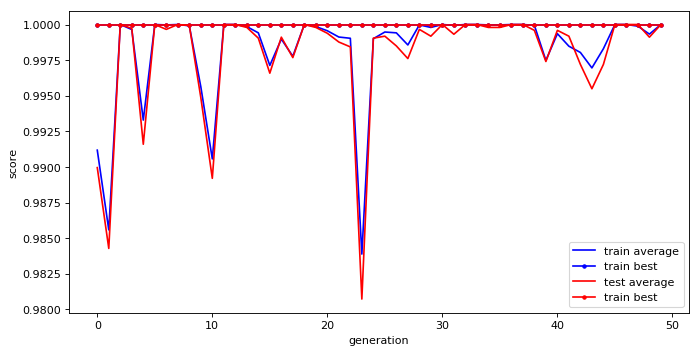

In [5]:
fS = FeatureSelection(data,y,min_col,features,population) 
fS.init_population()
best = fS.train(50)